# Capstone Project - Predicting Smartphone Purchase of Multi Category Store
## Part 2 - Product Weekly Sales Prediction

### Table of Contents

* [Section 1.  Import dataset](#section_1)
* [Section 2. Dynamic pricing](#section_2)
    * [2.1 Price elasticity](#section_2_a)
* [Section 3. Weekly sales prediction](#section_3)
    * [3.1 Feature engineering](#section_3_a)
        * [3.1.1 Historical weekly statics (sales)](#section_3_1_1)
        * [3.1.2 Historical weekly statics (views)](#section_3_1_2)
        * [3.1.3 Historical weekly statics (carts)](#section_3_1_3)
    * [3.2 Modelling](#section_3_b)
        * [3.2.1 Linear regression and feature/target transforming](#section_3_2_1)
        * [3.2.2 Model comparison](#section_3_2_2)
        * [3.2.3 Feature importance](#section_3_2_3)
    * [3.3 Summary](#section_3_c)


## Section 1.  Import dataset <a class="anchor" id="section_1"> </a> 

Import libraries

In [138]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import calendar

from scipy import stats

from sklearn.compose import ColumnTransformer
from sklearn.compose import TransformedTargetRegressor
from sklearn.pipeline import Pipeline
#from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder

from sklearn.metrics import mean_squared_error, mean_absolute_error

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import Lasso, LassoCV
from sklearn.svm import LinearSVR, SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import cross_val_score

# Garbage Collector to free up memory
import gc                         
gc.enable()                       # Activate 

In [2]:
column_name_and_dtype = {'event_type': 'category',
                         'product_id': 'category',
                         'category_id': 'category',
                         'category_code': 'category',
                         'brand': 'category',
                         'user_id': 'category',
                         'user_session': 'category'}

use_columns = ['event_time',
               'event_type',
               'product_id',
               'price',
               'category_code',
               'brand',
               'user_session',
              ]

In [3]:
product_summary = pd.read_csv('csv_files/product_summary.csv',
                              dtype = column_name_and_dtype)

In [4]:
%%time
df_ep = pd.read_csv('csv_files/elastic_price.gz', 
                    compression = 'gzip', 
                    low_memory = True, 
                    dtype = column_name_and_dtype,
                    parse_dates = ['event_time'])


Wall time: 30.4 s


In [5]:
product_summary.head()

,product_id,price_count,brand,category,product
0,1005169,183,samsung,electronics,smartphone
1,1005168,178,samsung,electronics,smartphone
2,1005171,173,samsung,electronics,smartphone
3,1005100,168,samsung,electronics,smartphone
4,1004874,163,samsung,electronics,smartphone


## Section 2.  Dynamic pricing <a class="anchor" id="section_2"></a> 

In [6]:
df_ep.head()

,event_time,event_type,product_id,price
0,2019-10-01 00:00:19+00:00,view,1005135,1747.79
1,2019-10-01 00:00:20+00:00,view,1003306,588.77
2,2019-10-01 00:00:24+00:00,view,1003306,588.77
3,2019-10-01 00:00:36+00:00,view,1004767,254.82
4,2019-10-01 00:00:43+00:00,view,1005135,1747.79


In [7]:
df_ep['week_id'] = df_ep['event_time'].dt.week
df_ep['event_time'] = df_ep['event_time'].dt.date

In [8]:
purchase = df_ep[df_ep['event_type']=='purchase'].reset_index(drop = True)
purchase.head()

,event_time,event_type,product_id,price,week_id
0,2019-10-01,purchase,1004246,736.18,40
1,2019-10-01,purchase,1005135,1747.79,40
2,2019-10-01,purchase,1004870,286.86,40
3,2019-10-01,purchase,1004767,254.82,40
4,2019-10-01,purchase,1004249,739.81,40


In [9]:
df_sales = purchase.groupby(['product_id','week_id']) \
                   .agg(average_price = ('price' , 'mean'),
                        sales = ('event_type' , 'count'),
                        n_days = ('event_time' , 'nunique')) \
                   .reset_index()
df_sales['norm_sales'] = df_sales['sales'] / df_sales['n_days'] * 7

df_sales.dropna(inplace = True)

df_sales.head()

,product_id,week_id,average_price,sales,n_days,norm_sales
0,1003306,40,585.230208,721,6,841.166667
1,1003306,41,581.989253,817,7,817.000000
2,1003306,42,587.557523,1094,7,1094.000000
3,1003306,43,581.470236,1185,7,1185.000000
4,1003306,44,578.071709,983,7,983.000000


### Section 2.1  Price elasticity <a class="anchor" id="section_2_a"></a> 

Plot  price elasticity of demand curve of some products

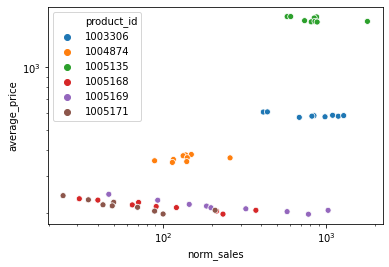

In [10]:
plist = ['1005169', '1005168',  '1005171', '1005171', '1004874', '1005135', '1003306']
fig = plt.figure()
sns.scatterplot(data = df_sales[df_sales['product_id'].isin(plist)],
                x = 'norm_sales',
                y = 'average_price',
                hue = 'product_id',
                )
ax = plt.gca()
ax.set_xscale('log')
ax.set_yscale('log')

In [11]:
df_elasticity = purchase.groupby(['product_id']) \
                        .agg(sales = ('event_type' , 'count'),
                             price_max = ('price' , 'max'),
                             price_min = ('price' , 'min')) \
                        .reset_index()
df_elasticity.head()

,product_id,sales,price_max,price_min
0,1003306,7366,616.49,573.75
1,1004227,2514,1157.56,952.15
2,1004230,281,1273.90,1106.16
3,1004240,697,1286.75,1052.90
4,1004246,4461,849.16,727.02


##### Fitting with OLS

In [12]:
for idx, product_id in enumerate(df_elasticity['product_id']):
    filtered = df_sales[df_sales['product_id'] == product_id]
    x = np.log(filtered['average_price'])
    y = np.log(filtered['norm_sales'])
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    
    df_elasticity.loc[idx,'elasticity'] = slope
    df_elasticity.loc[idx,'R2_score'] = r_value**2
    df_elasticity.loc[idx,'p_value'] = p_value
    

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_stats_mstats_common.py:130: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_stats_mstats_common.py:140: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_stats_mstats_common.py:142: RuntimeWarning: invalid value encountered in double_scalars
  sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)


In [13]:
df_elasticity.dropna(inplace = True)
df_elasticity

,product_id,sales,price_max,price_min,elasticity,R2_score,p_value
0,1003306,7366,616.49,573.75,-14.149603,0.551766,0.021854
1,1004227,2514,1157.56,952.15,2.347238,0.051238,0.558104
2,1004230,281,1273.90,1106.16,-3.788577,0.029149,0.660528
3,1004240,697,1286.75,1052.90,-3.693771,0.204470,0.221698
4,1004246,4461,849.16,727.02,-1.489011,0.015786,0.747384
...,...,...,...,...,...,...,...
72,7006302,45,124.84,120.57,7.143430,0.025095,0.683955
73,1005195,828,149.30,104.25,-9.356976,0.723558,0.007427
74,1005211,834,231.38,169.09,-6.656979,0.862543,0.000857
75,1005212,2651,231.38,169.09,-10.668468,0.925553,0.000133


In [14]:
df_elasticity = df_elasticity.merge(product_summary[['category', 'product', 'brand', 'product_id']],
                                    how = 'left',
                                    on = 'product_id')

##### Based on null hypothesis test, only p-value less than 0.05 can reject the hypothesis, meaning that it is truely price elastic. From the table below, it can be seen that only 20 products (out of 76) are price elastic.

In [15]:
plist = df_elasticity[df_elasticity['p_value'] < 0.05].sort_values(by = 'elasticity')
plist

,product_id,sales,price_max,price_min,elasticity,R2_score,p_value,category,product,brand
50,1005165,429,321.50,280.05,-14.994772,0.606550,0.013394,electronics,smartphone,xiaomi
0,1003306,7366,616.49,573.75,-14.149603,0.551766,0.021854,electronics,smartphone,apple
53,1005169,3105,251.94,192.26,-14.057823,0.876697,0.000202,electronics,smartphone,samsung
52,1005168,1141,251.97,179.66,-13.624753,0.868170,0.000256,electronics,smartphone,samsung
68,7005191,68,185.35,162.39,-13.525886,0.520938,0.028138,kids,carriage,belecoo
37,1005116,7036,1092.68,979.43,-12.650798,0.450698,0.047708,electronics,smartphone,apple
48,1005160,9311,244.28,190.61,-12.126380,0.662509,0.007585,electronics,smartphone,xiaomi
33,1005100,14769,154.42,128.45,-11.146122,0.831041,0.000619,electronics,smartphone,samsung
49,1005161,4375,244.28,191.54,-10.809528,0.702208,0.004793,electronics,smartphone,xiaomi
74,1005212,2651,231.38,169.09,-10.668468,0.925553,0.000133,electronics,smartphone,samsung


In [ ]:
fig = plt.figure()
sns.scatterplot(data = df_sales[df_sales['product_id'].isin(plist)],
                x = 'norm_sales',
                y = 'average_price',
                hue = 'product_id',
                )
ax = plt.gca()
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('sales', fontsize=13, fontweight = 'bold')
ax.set_ylabel('average price', fontsize=13, fontweight = 'bold')
ax.legend().set_visible(False)
fig.savefig('output/elastic_price.png', transparent=True, bbox_inches='tight', dpi=300)

In [16]:
df_elasticity.to_csv('output/price_elasticity.csv', index = False)

Inspect the price changes of one selected product

In [17]:
purchase[(purchase['product_id']=='1004650') & (purchase['week_id']==46)]

,event_time,event_type,product_id,price,week_id
170951,2019-11-11,purchase,1004650,614.95,46
173077,2019-11-11,purchase,1004650,614.92,46
173413,2019-11-11,purchase,1004650,614.89,46
176280,2019-11-12,purchase,1004650,614.81,46
180585,2019-11-13,purchase,1004650,614.73,46
188130,2019-11-16,purchase,1004650,642.72,46
190554,2019-11-16,purchase,1004650,640.94,46
192050,2019-11-16,purchase,1004650,640.94,46
196553,2019-11-16,purchase,1004650,640.94,46
197918,2019-11-16,purchase,1004650,642.72,46


## Section 3  Weekly sales prediction <a class="anchor" id="section_3"></a> 

### Section 3.1  Feature engineering <a class="anchor" id="section_3_a"></a> 


#### Section 3.1.1  Historical weekly statics (sales) <a class="anchor" id="section_3_1_1"></a> 


In [18]:
df_sales.drop(columns = ['n_days', 'norm_sales'], inplace = True)

In [19]:
dummy = df_sales.head(4).copy()
dummy['product_id'] = '0'
dummy['week_id'] = df_sales['week_id'].min() - np.arange(4) - 1

df = pd.concat([df_sales, dummy]).reset_index(drop=True)
#pv = pd.pivot_table(df, values='sales', index = 'product_id', columns='week_id', fill_value=0)
pv = pd.pivot_table(df, values='sales', index = 'product_id', columns='week_id')
pv

week_id,36,37,38,39,40,41,42,43,44,45,46,47,48
product_id,,,,,,,,,,,,,
0,1185.0,1094.0,817.0,721.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1003306,NaN,NaN,NaN,NaN,721.0,817.0,1094.0,1185.0,983.0,684.0,1096.0,412.0,374.0
1004227,NaN,NaN,NaN,NaN,299.0,334.0,398.0,326.0,236.0,281.0,304.0,148.0,188.0
1004230,NaN,NaN,NaN,NaN,34.0,42.0,48.0,46.0,19.0,21.0,52.0,12.0,7.0
1004240,NaN,NaN,NaN,NaN,83.0,115.0,103.0,77.0,69.0,59.0,102.0,48.0,41.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7005190,NaN,NaN,NaN,NaN,NaN,1.0,3.0,7.0,3.0,5.0,2.0,3.0,NaN
7005191,NaN,NaN,NaN,NaN,7.0,17.0,3.0,8.0,5.0,8.0,16.0,2.0,2.0
7005237,NaN,NaN,NaN,NaN,9.0,9.0,8.0,4.0,10.0,8.0,30.0,10.0,14.0


In [20]:
df = pd.melt(pv.reset_index().loc[1:],
             id_vars = 'product_id',
             value_name='sales') \
       .sort_values(['product_id','week_id'])

df['sales_last_1w'] = df.rolling(2).sum()['sales'] - df['sales']
df['sales_last_2w'] = df.rolling(3).sum()['sales'] - df['sales']
df['sales_last_4w'] = df.rolling(5).sum()['sales'] - df['sales']

df = df[df['week_id'] >= df_sales['week_id'].min()]
df.head(16)

,product_id,week_id,sales,sales_last_1w,sales_last_2w,sales_last_4w
308,1003306,40,721.0,NaN,NaN,NaN
385,1003306,41,817.0,721.0,NaN,NaN
462,1003306,42,1094.0,817.0,1538.0,NaN
539,1003306,43,1185.0,1094.0,1911.0,NaN
616,1003306,44,983.0,1185.0,2279.0,3817.0
693,1003306,45,684.0,983.0,2168.0,4079.0
770,1003306,46,1096.0,684.0,1667.0,3946.0
847,1003306,47,412.0,1096.0,1780.0,3948.0
924,1003306,48,374.0,412.0,1508.0,3175.0
309,1004227,40,299.0,NaN,NaN,NaN


In [21]:
df_sales = df_sales.merge(df[['product_id', 'week_id', 'sales_last_1w', 'sales_last_2w', 'sales_last_4w']],
                                    how = 'left',
                                    on = ['product_id','week_id'])
df_sales.head(16)

,product_id,week_id,average_price,sales,sales_last_1w,sales_last_2w,sales_last_4w
0,1003306,40,585.230208,721,NaN,NaN,NaN
1,1003306,41,581.989253,817,721.0,NaN,NaN
2,1003306,42,587.557523,1094,817.0,1538.0,NaN
3,1003306,43,581.470236,1185,1094.0,1911.0,NaN
4,1003306,44,578.071709,983,1185.0,2279.0,3817.0
5,1003306,45,574.300804,684,983.0,2168.0,4079.0
6,1003306,46,585.508923,1096,684.0,1667.0,3946.0
7,1003306,47,609.120728,412,1096.0,1780.0,3948.0
8,1003306,48,610.073610,374,412.0,1508.0,3175.0
9,1004227,40,1008.448161,299,NaN,NaN,NaN


#### Section 3.1.2  Historical weekly statics (views) <a class="anchor" id="section_3_1_2"></a> 


In [22]:
filtered = df_ep[df_ep['event_type']=='view'].reset_index(drop = True)
grouped = filtered.groupby(['product_id','week_id']) \
                  .agg(views = ('event_type' , 'count')) \
                  .reset_index()

df = pd.concat([grouped, dummy.rename(columns = {'sales': 'views'})]).reset_index(drop=True)
pv = pd.pivot_table(df, values='views', index = 'product_id', columns='week_id')

df = pd.melt(pv.reset_index().loc[1:],
             id_vars = 'product_id',
             value_name='views') \
       .sort_values(['product_id','week_id'])

df['views_last_1w'] = df.rolling(2).sum()['views'] - df['views']
df['views_last_2w'] = df.rolling(3).sum()['views'] - df['views']
df['views_last_4w'] = df.rolling(5).sum()['views'] - df['views']

df = df[df['week_id'] >= df_sales['week_id'].min()]

df_sales = df_sales.merge(df[['product_id', 'week_id', 'views_last_1w', 'views_last_2w', 'views_last_4w']],
                                    how = 'left',
                                    on = ['product_id','week_id'])
df_sales.head(16)

,product_id,week_id,average_price,sales,sales_last_1w,sales_last_2w,sales_last_4w,views_last_1w,views_last_2w,views_last_4w
0,1003306,40,585.230208,721,NaN,NaN,NaN,NaN,NaN,NaN
1,1003306,41,581.989253,817,721.0,NaN,NaN,19121.0,NaN,NaN
2,1003306,42,587.557523,1094,817.0,1538.0,NaN,22962.0,42083.0,NaN
3,1003306,43,581.470236,1185,1094.0,1911.0,NaN,24931.0,47893.0,NaN
4,1003306,44,578.071709,983,1185.0,2279.0,3817.0,25092.0,50023.0,92106.0
5,1003306,45,574.300804,684,983.0,2168.0,4079.0,23484.0,48576.0,96469.0
6,1003306,46,585.508923,1096,684.0,1667.0,3946.0,21367.0,44851.0,94874.0
7,1003306,47,609.120728,412,1096.0,1780.0,3948.0,35508.0,56875.0,105451.0
8,1003306,48,610.073610,374,412.0,1508.0,3175.0,12559.0,48067.0,92918.0
9,1004227,40,1008.448161,299,NaN,NaN,NaN,NaN,NaN,NaN


#### Section 3.1.3  Historical weekly statics (carts) <a class="anchor" id="section_3_1_3"></a> 


In [23]:
filtered = df_ep[df_ep['event_type']=='cart'].reset_index(drop = True)
grouped = filtered.groupby(['product_id','week_id']) \
                  .agg(carts = ('event_type' , 'count')) \
                  .reset_index()

df = pd.concat([grouped, dummy.rename(columns = {'sales': 'carts'})]).reset_index(drop=True)
pv = pd.pivot_table(df, values='carts', index = 'product_id', columns='week_id')

df = pd.melt(pv.reset_index().loc[1:],
             id_vars = 'product_id',
             value_name='carts') \
       .sort_values(['product_id','week_id'])

df['carts_last_1w'] = df.rolling(2).sum()['carts'] - df['carts']
df['carts_last_2w'] = df.rolling(3).sum()['carts'] - df['carts']
df['carts_last_4w'] = df.rolling(5).sum()['carts'] - df['carts']

df = df[df['week_id'] >= df_sales['week_id'].min()]

df_sales = df_sales.merge(df[['product_id', 'week_id', 'carts_last_1w', 'carts_last_2w', 'carts_last_4w']],
                                    how = 'left',
                                    on = ['product_id','week_id'])
df_sales.head(16)

,product_id,week_id,average_price,sales,sales_last_1w,sales_last_2w,sales_last_4w,views_last_1w,views_last_2w,views_last_4w,carts_last_1w,carts_last_2w,carts_last_4w
0,1003306,40,585.230208,721,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1003306,41,581.989253,817,721.0,NaN,NaN,19121.0,NaN,NaN,1326.0,NaN,NaN
2,1003306,42,587.557523,1094,817.0,1538.0,NaN,22962.0,42083.0,NaN,1053.0,2379.0,NaN
3,1003306,43,581.470236,1185,1094.0,1911.0,NaN,24931.0,47893.0,NaN,1817.0,2870.0,NaN
4,1003306,44,578.071709,983,1185.0,2279.0,3817.0,25092.0,50023.0,92106.0,2224.0,4041.0,6420.0
5,1003306,45,574.300804,684,983.0,2168.0,4079.0,23484.0,48576.0,96469.0,1165.0,3389.0,6259.0
6,1003306,46,585.508923,1096,684.0,1667.0,3946.0,21367.0,44851.0,94874.0,1138.0,2303.0,6344.0
7,1003306,47,609.120728,412,1096.0,1780.0,3948.0,35508.0,56875.0,105451.0,5218.0,6356.0,9745.0
8,1003306,48,610.073610,374,412.0,1508.0,3175.0,12559.0,48067.0,92918.0,935.0,6153.0,8456.0
9,1004227,40,1008.448161,299,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [25]:
df_sales = df_sales.merge(df_elasticity[['product_id', 'elasticity', 'product', 'brand']],
                          how = 'left',
                          on = 'product_id')
df_sales.head(10)

,product_id,week_id,average_price,sales,sales_last_1w,sales_last_2w,sales_last_4w,views_last_1w,views_last_2w,views_last_4w,carts_last_1w,carts_last_2w,carts_last_4w,elasticity,product,brand
0,1003306,40,585.230208,721,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-14.149603,smartphone,apple
1,1003306,41,581.989253,817,721.0,NaN,NaN,19121.0,NaN,NaN,1326.0,NaN,NaN,-14.149603,smartphone,apple
2,1003306,42,587.557523,1094,817.0,1538.0,NaN,22962.0,42083.0,NaN,1053.0,2379.0,NaN,-14.149603,smartphone,apple
3,1003306,43,581.470236,1185,1094.0,1911.0,NaN,24931.0,47893.0,NaN,1817.0,2870.0,NaN,-14.149603,smartphone,apple
4,1003306,44,578.071709,983,1185.0,2279.0,3817.0,25092.0,50023.0,92106.0,2224.0,4041.0,6420.0,-14.149603,smartphone,apple
5,1003306,45,574.300804,684,983.0,2168.0,4079.0,23484.0,48576.0,96469.0,1165.0,3389.0,6259.0,-14.149603,smartphone,apple
6,1003306,46,585.508923,1096,684.0,1667.0,3946.0,21367.0,44851.0,94874.0,1138.0,2303.0,6344.0,-14.149603,smartphone,apple
7,1003306,47,609.120728,412,1096.0,1780.0,3948.0,35508.0,56875.0,105451.0,5218.0,6356.0,9745.0,-14.149603,smartphone,apple
8,1003306,48,610.073610,374,412.0,1508.0,3175.0,12559.0,48067.0,92918.0,935.0,6153.0,8456.0,-14.149603,smartphone,apple
9,1004227,40,1008.448161,299,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.347238,smartphone,apple


In [26]:
df_sales.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 658 entries, 0 to 657
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   product_id     658 non-null    object  
 1   week_id        658 non-null    object  
 2   average_price  658 non-null    float64 
 3   sales          658 non-null    int64   
 4   sales_last_1w  575 non-null    float64 
 5   sales_last_2w  499 non-null    float64 
 6   sales_last_4w  353 non-null    float64 
 7   views_last_1w  589 non-null    float64 
 8   views_last_2w  516 non-null    float64 
 9   views_last_4w  369 non-null    float64 
 10  carts_last_1w  589 non-null    float64 
 11  carts_last_2w  516 non-null    float64 
 12  carts_last_4w  369 non-null    float64 
 13  elasticity     657 non-null    float64 
 14  product        657 non-null    object  
 15  brand          657 non-null    category
dtypes: category(1), float64(11), int64(1), object(3)
memory usage: 277.1+ KB


In [27]:
df_sales.loc[df_sales['product'].isna(), 'product'] = 'unknown'

#df_sales['brand'].cat.add_categories('unknown')
df_sales['brand'] = df_sales['brand'].astype('string')
df_sales.loc[df_sales['brand'].isna(), 'brand'] = 'unknown'
df_sales['brand'] = df_sales['brand'].astype('category')

# for numerical columns
df_sales.replace(np.nan, 1.0, inplace = True)


In [28]:
df_sales.isna().sum()

product_id       0
week_id          0
average_price    0
sales            0
sales_last_1w    0
sales_last_2w    0
sales_last_4w    0
views_last_1w    0
views_last_2w    0
views_last_4w    0
carts_last_1w    0
carts_last_2w    0
carts_last_4w    0
elasticity       0
product          0
brand            0
dtype: int64

### Section 3.2  Modelling <a class="anchor" id="section_3_b"></a> 


In [105]:
lin_features = ['elasticity',
#                'average_price', 
               ]

log_features = ['sales_last_1w', 'sales_last_2w', 'sales_last_4w',
                'carts_last_1w', 'carts_last_2w', 'carts_last_4w',
                'views_last_1w', 'views_last_2w', 'views_last_4w',
                'average_price', 
               ]

from sklearn.preprocessing import FunctionTransformer
log_transformer = FunctionTransformer(np.log1p, validate=True)

lin_transformer = Pipeline(steps=[
#    ('imputer', SimpleImputer(strategy='median')),
#    ('scaler', StandardScaler()),
    ('scaler', MinMaxScaler()),
    ])

categorical_features = ['product', 'brand']
#categorical_features = ['product']
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num_log', log_transformer, log_features),
        ('num_lin', lin_transformer, lin_features),
#        ('cat', categorical_transformer, categorical_features)],
        ],
#    remainder="drop",
#    remainder="passthrough",
)

numerical_features = log_features + lin_features
#features = numerical_features + categorical_features
features = numerical_features
#display(features)

target = ['sales']

In [106]:
current_week = df_sales['week_id'].max()

X_train = df_sales[df_sales['week_id'] < current_week][features]
y_train = df_sales[df_sales['week_id'] < current_week][target]

X_test = df_sales[df_sales['week_id'] == current_week][features]
y_test = df_sales[df_sales['week_id'] == current_week][target]

In [101]:
X_train.head()

,sales_last_1w,sales_last_2w,sales_last_4w,carts_last_1w,carts_last_2w,carts_last_4w,views_last_1w,views_last_2w,views_last_4w,average_price,elasticity
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,585.230208,-14.149603
1,721.0,1.0,1.0,1326.0,1.0,1.0,19121.0,1.0,1.0,581.989253,-14.149603
2,817.0,1538.0,1.0,1053.0,2379.0,1.0,22962.0,42083.0,1.0,587.557523,-14.149603
3,1094.0,1911.0,1.0,1817.0,2870.0,1.0,24931.0,47893.0,1.0,581.470236,-14.149603
4,1185.0,2279.0,3817.0,2224.0,4041.0,6420.0,25092.0,50023.0,92106.0,578.071709,-14.149603


In [32]:
#X_train['product'].value_counts()

#### Section 3.2.1  Linear regression and feature/target transforming <a class="anchor" id="section_3_2_1"></a> 


In [33]:
df = df_sales.dropna()
X1 = df[df['week_id'] < current_week][numerical_features]
y1 = df[df['week_id'] < current_week][target]

X2 = df[df['week_id'] == current_week][numerical_features]
y2 = df[df['week_id'] == current_week][target]

reg = LinearRegression()
reg.fit(X1, y1)
y_pd = reg.predict(X2)

print("OLS R2_score: %.4f" %reg.score(X2, y2))
print("MSE: %.4f" %mean_squared_error(y2, y_pd))
print("MAE: %.4f" %mean_absolute_error(y2, y_pd))


OLS R2_score: -1.7182
MSE: 1566001.2521
MAE: 623.3573


In [34]:
# Append regressor to preprocessing pipeline.
# Now we have a full prediction pipeline.
regr = Pipeline(steps=[('preprocessor', preprocessor),
                       ('regressor', LinearRegression())])

regr.fit(X_train, y_train)

y_pred = regr.predict(X_test)

print("OLS R2_score: %.4f" %regr.score(X_test, y_test))
print("MSE: %.4f" %mean_squared_error(y_test, y_pred))
print("MAE: %.4f" %mean_absolute_error(y_test, y_pred))

OLS R2_score: 0.3960
MSE: 347959.8659
MAE: 430.9034


In [35]:
# Now transform the target to np.log(target)
regr_trans = TransformedTargetRegressor(regressor = regr,
                                        func = np.log,
                                        inverse_func = np.exp)

regr_trans.fit(X_train, y_train)

y_pred_trans = regr_trans.predict(X_test)

print("--- Transformed target regressor ---")
print("OLS R2_score: %.4f" %regr_trans.score(X_test, y_test))
print("MSE: %.4f" %mean_squared_error(y_test, y_pred_trans))
print("MAE: %.4f" %mean_absolute_error(y_test, y_pred_trans))


#score = cross_val_score(regr, X, y, cv=5)
#print('TransformedTarget: ')
#print(('  R^2 ={:.3f}  std {:.3f}').format(np.mean(score), np.std(score)))


--- Transformed target regressor ---
OLS R2_score: 0.9185
MSE: 46942.5587
MAE: 95.0201


#### Section 3.2.2  Model comparison <a class="anchor" id="section_3_2_2"></a> 


In [36]:
def model_fit_predict(name, reg):
    regr = Pipeline(steps=[('preprocessor', preprocessor),
                           ('regressor', reg)])

    regr_trans = TransformedTargetRegressor(regressor = regr,
                                            func = np.log,
                                            inverse_func = np.exp)

    regr_trans.fit(X_train, y_train)

    y_pred_trans = regr_trans.predict(X_test)

    r2_score = regr_trans.score(X_test, y_test)
    mse = mean_squared_error(y_test, y_pred_trans)
    mae = mean_absolute_error(y_test, y_pred_trans)
    print(name.rjust(16), end=':   ')
    print(('R^2 ={:.3f}  mse {:.3f} mae {:.3f}').format(r2_score, mse, mae))
    

In [146]:
models = [('Linear', LinearRegression()),
          ('Ridge', Ridge()),
          ('Lasso', Lasso(alpha = 10e-3)),
          ('RidgeCV', RidgeCV()),
          ('LassoCV', LassoCV(alphas = [10e-1, 10e-2, 10e-3, 10e-4])),
#          ('SGDRegressor', SGDRegressor()),
#          ('LinearSVR', LinearSVR()),
          ('SVR linear', SVR(kernel = 'linear')),
          ('SVR', SVR(kernel = 'rbf')),
#          ('DecisionTree', DecisionTreeRegressor()),
          ('AdaBoost', AdaBoostRegressor(learning_rate = 0.5, n_estimators = 3, loss = 'square')),
          ('GradientBoosting', GradientBoostingRegressor()),
          ('RandomForest', RandomForestRegressor()),
          ]


In [147]:
for name, reg in models:
    model_fit_predict(name, reg)


          Linear:   R^2 =0.950  mse 28876.105 mae 86.476
           Ridge:   R^2 =0.953  mse 27082.650 mae 84.788
           Lasso:   R^2 =0.972  mse 15996.058 mae 71.060
         RidgeCV:   R^2 =0.953  mse 27082.650 mae 84.788
         LassoCV:   R^2 =0.972  mse 15996.058 mae 71.060
             SVR:   R^2 =0.970  mse 17042.560 mae 71.148
        AdaBoost:   R^2 =0.891  mse 62954.103 mae 116.018
GradientBoosting:   R^2 =0.875  mse 71962.342 mae 82.015
    RandomForest:   R^2 =0.944  mse 32273.042 mae 93.277


In [135]:
clf = AdaBoostRegressor(learning_rate = 0.5, n_estimators = 4, loss = 'square')


regr_trans = TransformedTargetRegressor(regressor = clf,
                                        func = np.log,
                                        inverse_func = np.exp)

regr_trans.fit(X_train, y_train)

y_pred_trans = regr_trans.predict(X_test)

print("--- XGBRegressor ---")
print("OLS R2_score: %.4f" %regr_trans.score(X_test, y_test))
print("MSE: %.4f" %mean_squared_error(y_test, y_pred_trans))
print("MAE: %.4f" %mean_absolute_error(y_test, y_pred_trans))

--- XGBRegressor ---
OLS R2_score: 0.7796
MSE: 126985.7289
MAE: 140.0401


In [139]:
import xgboost as xgb

clf = xgb.XGBRegressor(n_estimators = 4,
                       learning_rate = 0.75)

regr_trans = TransformedTargetRegressor(regressor = clf,
                                        func = np.log,
                                        inverse_func = np.exp)

regr_trans.fit(X_train, y_train,
               eval_set=[(X_train, y_train), (X_test, y_test)],
               eval_metric = 'rmse',
               verbose = False,
               early_stopping_rounds = 20)

y_pred_trans = regr_trans.predict(X_test)

print("--- XGBRegressor ---")
print("OLS R2_score: %.4f" %regr_trans.score(X_test, y_test))
print("MSE: %.4f" %mean_squared_error(y_test, y_pred_trans))
print("MAE: %.4f" %mean_absolute_error(y_test, y_pred_trans))

--- XGBRegressor ---
OLS R2_score: 0.9549
MSE: 25963.3292
MAE: 85.5274


In [103]:
regr_trans.regressor_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.74, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=4, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

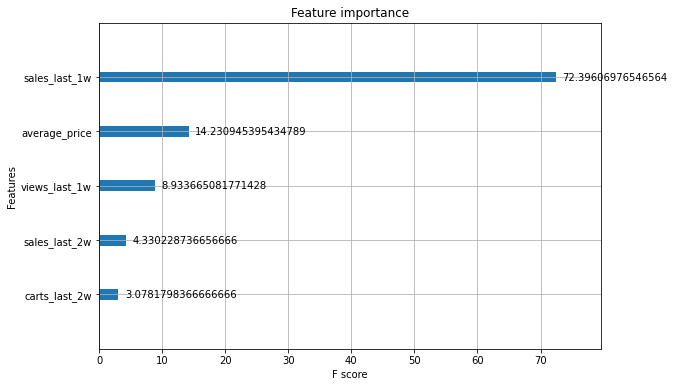

In [104]:
from xgboost import plot_importance

fig, ax = plt.subplots(figsize=[9,6])
plot_importance(regr_trans.regressor_, max_num_features=5, importance_type ='gain', ax = ax)


In [93]:
keys

['sales_last_1w',
 'average_price',
 'views_last_1w',
 'elasticity',
 'sales_last_2w',
 'carts_last_1w',
 'sales_last_4w',
 'views_last_2w',
 'views_last_4w',
 'carts_last_2w']

In [94]:
feature_important = regr_trans.regressor_.get_booster().get_score(importance_type='weight')
feature_important = regr_trans.regressor_.get_booster().get_score(importance_type='gain')
keys = list(feature_important.keys())
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data

,score
sales_last_1w,72.396070
average_price,14.230945
views_last_1w,8.933665
sales_last_2w,4.330229
carts_last_2w,3.078180
elasticity,2.678863
carts_last_1w,2.423945
views_last_4w,1.349997
views_last_2w,0.923385
sales_last_4w,0.358413


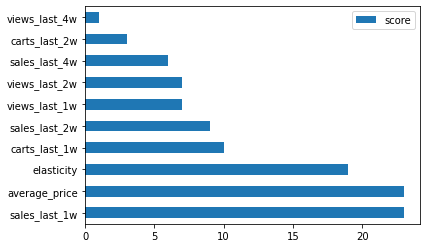

In [92]:
data.plot(kind='barh')

#### Section 3.2.3  Feature importance <a class="anchor" id="section_3_2_3"></a> 


In [148]:
regr = Pipeline(steps=[('preprocessor', preprocessor),
                       ('regressor', Lasso(alpha = 10e-3))])

regr_trans = TransformedTargetRegressor(regressor = regr,
                                        func = np.log,
                                        inverse_func = np.exp)

fitted = regr_trans.fit(X_train, y_train)
y_pred_trans = regr_trans.predict(X_test)

In [149]:
regr_trans

TransformedTargetRegressor(func=<ufunc 'log'>, inverse_func=<ufunc 'exp'>,
                           regressor=Pipeline(steps=[('preprocessor',
                                                      ColumnTransformer(transformers=[('num_log',
                                                                                       FunctionTransformer(func=<ufunc 'log1p'>,
                                                                                                           validate=True),
                                                                                       ['sales_last_1w',
                                                                                        'sales_last_2w',
                                                                                        'sales_last_4w',
                                                                                        'carts_last_1w',
                                                                                     

In [150]:
#regr_trans.regressor.named_steps['regressor'].coef_
regr_trans.regressor.named_steps
#classifier = regr_trans.best_estimator_.named_steps['regressor']

{'preprocessor': ColumnTransformer(transformers=[('num_log',
                                  FunctionTransformer(func=<ufunc 'log1p'>,
                                                      validate=True),
                                  ['sales_last_1w', 'sales_last_2w',
                                   'sales_last_4w', 'carts_last_1w',
                                   'carts_last_2w', 'carts_last_4w',
                                   'views_last_1w', 'views_last_2w',
                                   'views_last_4w', 'average_price']),
                                 ('num_lin',
                                  Pipeline(steps=[('scaler', MinMaxScaler())]),
                                  ['elasticity'])]),
 'regressor': Lasso(alpha=0.01)}

In [151]:
regr_trans.regressor_.named_steps['regressor'].coef_

array([ 1.38661449,  0.03427591,  0.07726182, -0.02632616,  0.05221055,
        0.01467827, -0.59702084, -0.07112803, -0.04676382,  0.10270783,
        0.        ])

In [152]:
#res = y_test
res = df_sales[df_sales['week_id'] == current_week][['product_id','product','brand','sales']]
res['sales_prediction'] = y_pred_trans.round(0).astype('int')
res

,product_id,product,brand,sales,sales_prediction
8,1003306,smartphone,apple,374,509
17,1004227,smartphone,apple,188,157
26,1004230,smartphone,apple,7,19
35,1004240,smartphone,apple,41,87
44,1004246,smartphone,apple,364,413
...,...,...,...,...,...
626,7006302,carriage,wingoffly,3,7
634,1005195,smartphone,xiaomi,163,172
642,1005211,smartphone,samsung,152,198
650,1005212,smartphone,samsung,734,711


In [153]:
res.isna().sum()

product_id          0
product             0
brand               0
sales               0
sales_prediction    0
dtype: int64

In [154]:
r2_score = regr_trans.score(X_test, y_test)
mse = mean_squared_error(y_test, y_pred_trans)
mae = mean_absolute_error(y_test, y_pred_trans)

score_str=(r'$R^2={:.3f}$' + '\n' + r'$MAE={:.3f}$').format(r2_score, mae)

In [155]:
ax_max = np.max([y_test.to_numpy().ravel().max(), y_pred_trans.max()])*1.01
ax_min = np.min([y_test.to_numpy().ravel().min(), y_pred_trans.min()])

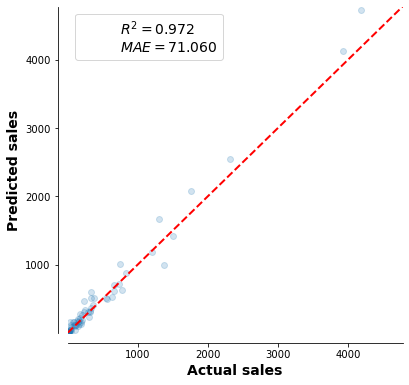

In [156]:
fig, ax = plt.subplots(figsize=[6,6])

ax.plot([ax_min, ax_max], [ax_min, ax_max], '--r', linewidth=2)
ax.scatter(y_test, y_pred_trans, alpha=0.2)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()
ax.spines['left'].set_position(('outward', 10))
ax.spines['bottom'].set_position(('outward', 10))
ax.set_xlim([ax_min, ax_max])
ax.set_ylim([ax_min, ax_max])
ax.set_xlabel('Actual sales',fontsize=14,fontweight='bold')
ax.set_ylabel('Predicted sales',fontsize=14,fontweight='bold')
extra = plt.Rectangle((0, 0), 0, 0, fc="w", fill=False,
                      edgecolor='none', linewidth=0)
ax.legend([extra], [score_str], loc='upper left', prop={'size': 14})

plt.show()
fig.savefig('output/sales_prediction.png', transparent=True, bbox_inches='tight', dpi=300)

In [167]:
df = df_sales.copy(deep = True)
df[log_features] = np.log1p(df[log_features])
X1 = df[df['week_id'] < current_week][numerical_features]
y1 = np.log1p(df[df['week_id'] < current_week][target])

X2 = df[df['week_id'] == current_week][numerical_features]
y2 = np.log1p(df[df['week_id'] == current_week][target])

#reg = LinearRegression()
reg = Lasso(alpha = 10e-3)
reg.fit(X1, y1)
y_pd = reg.predict(X2)

print("R2_score: %.4f" %reg.score(X2, y2))
print("MSE: %.4f" %mean_squared_error(np.exp(y2), np.exp(y_pd)))
print("MAE: %.4f" %mean_absolute_error(np.exp(y2), np.exp(y_pd)))


R2_score: 0.9548
MSE: 9381.7636
MAE: 58.8593


In [173]:
dict_name = {'sales_last_1w': 'previous 1 week total purchase',
             'sales_last_2w': 'previous 2 weeks total purchase',
             'sales_last_4w': 'previous 4 weeks total purchase',
             'carts_last_1w': 'previous 1 week total cart',
             'carts_last_2w': 'previous 2 weeks total cart',
             'carts_last_4w': 'previous 4 weeks total cart',
             'views_last_1w': 'previous 1 week total view',
             'views_last_2w': 'previous 2 weeks total view',
             'views_last_4w': 'previous 4 weeks total view',
             'average_price': 'product price',
             'elasticity': 'price elasticity'
            }

df_feature_importance = pd.DataFrame(numerical_features, columns = ['feature'])
df_feature_importance['Lasso'] = reg.coef_.T
df_feature_importance['pipeline'] = regr_trans.regressor_.named_steps['regressor'].coef_.T
df_feature_importance['abs'] = np.abs(df_feature_importance['pipeline'])
df_feature_importance['name'] = df_feature_importance['feature'].map(dict_name)
df_feature_importance.sort_values(by = 'abs', ascending = False).set_index('name', inplace = True)
df_feature_importance

,feature,Lasso,pipeline,abs,name
0,sales_last_1w,1.330192,1.386614,1.386614,previous 1 week total purchase
1,sales_last_2w,0.050308,0.034276,0.034276,previous 2 weeks total purchase
2,sales_last_4w,0.076888,0.077262,0.077262,previous 4 weeks total purchase
3,carts_last_1w,-0.017609,-0.026326,0.026326,previous 1 week total cart
4,carts_last_2w,0.026954,0.052211,0.052211,previous 2 weeks total cart
5,carts_last_4w,0.000000,0.014678,0.014678,previous 4 weeks total cart
6,views_last_1w,-0.575440,-0.597021,0.597021,previous 1 week total view
7,views_last_2w,-0.064631,-0.071128,0.071128,previous 2 weeks total view
8,views_last_4w,-0.036217,-0.046764,0.046764,previous 4 weeks total view
9,average_price,0.076208,0.102708,0.102708,product price


In [66]:
df_feature_importance = pd.DataFrame(reg.coef_.T, index = numerical_features, columns = ['Lasso'])
df_feature_importance['pipeline'] = regr_trans.regressor_.named_steps['regressor'].coef_.T
df_feature_importance

,Lasso,pipeline
sales_last_1w,1.327154,1.383061
sales_last_2w,0.056598,0.040248
sales_last_4w,0.082892,0.085947
carts_last_1w,-0.008011,-0.015152
carts_last_2w,0.028553,0.056488
carts_last_4w,0.000000,0.012499
views_last_1w,-0.578818,-0.600873
views_last_2w,-0.069800,-0.077851
views_last_4w,-0.040525,-0.051443
average_price,0.000036,0.000064


In [67]:
df_feature_importance.to_csv('output/sales_feature_importance.csv')

In [159]:
import sklearn
import warnings

def get_feature_names(column_transformer):
    """Get feature names from all transformers.
    Returns
    -------
    feature_names : list of strings
        Names of the features produced by transform.
    """
    # Remove the internal helper function
    #check_is_fitted(column_transformer)
    
    # Turn loopkup into function for better handling with pipeline later
    def get_names(trans):
        # >> Original get_feature_names() method
        if trans == 'drop' or (
                hasattr(column, '__len__') and not len(column)):
            return []
        if trans == 'passthrough':
            if hasattr(column_transformer, '_df_columns'):
                if ((not isinstance(column, slice))
                        and all(isinstance(col, str) for col in column)):
                    return column
                else:
                    return column_transformer._df_columns[column]
            else:
                indices = np.arange(column_transformer._n_features)
                return ['x%d' % i for i in indices[column]]
        if not hasattr(trans, 'get_feature_names'):
        # >>> Change: Return input column names if no method avaiable
            # Turn error into a warning
            warnings.warn("Transformer %s (type %s) does not "
                                 "provide get_feature_names. "
                                 "Will return input column names if available"
                                 % (str(name), type(trans).__name__))
            # For transformers without a get_features_names method, use the input
            # names to the column transformer
            if column is None:
                return []
            else:
                return [name + "__" + f for f in column]

        return [name + "__" + f for f in trans.get_feature_names()]
    
    ### Start of processing
    feature_names = []
    
    # Allow transformers to be pipelines. Pipeline steps are named differently, so preprocessing is needed
    if type(column_transformer) == sklearn.pipeline.Pipeline:
        l_transformers = [(name, trans, None, None) for step, name, trans in column_transformer._iter()]
    else:
        # For column transformers, follow the original method
        l_transformers = list(column_transformer._iter(fitted=True))
    
    
    for name, trans, column, _ in l_transformers: 
        if type(trans) == sklearn.pipeline.Pipeline:
            # Recursive call on pipeline
            _names = get_feature_names(trans)
            # if pipeline has no transformer that returns names
            if len(_names)==0:
                _names = [name + "__" + f for f in column]
            feature_names.extend(_names)
        else:
            feature_names.extend(get_names(trans))
    
    return feature_names

In [168]:
get_feature_names(regr_trans.regressor_.named_steps['preprocessor'])

<ipython-input-159-914e3f59aa47>:33: UserWarning: Transformer num_log (type FunctionTransformer) does not provide get_feature_names. Will return input column names if available
  warnings.warn("Transformer %s (type %s) does not "
<ipython-input-159-914e3f59aa47>:33: UserWarning: Transformer scaler (type MinMaxScaler) does not provide get_feature_names. Will return input column names if available
  warnings.warn("Transformer %s (type %s) does not "


['num_log__sales_last_1w',
 'num_log__sales_last_2w',
 'num_log__sales_last_4w',
 'num_log__carts_last_1w',
 'num_log__carts_last_2w',
 'num_log__carts_last_4w',
 'num_log__views_last_1w',
 'num_log__views_last_2w',
 'num_log__views_last_4w',
 'num_log__average_price',
 'num_lin__elasticity']

In [165]:
preprocessor

ColumnTransformer(transformers=[('num_log',
                                 FunctionTransformer(func=<ufunc 'log1p'>,
                                                     validate=True),
                                 ['sales_last_1w', 'sales_last_2w',
                                  'sales_last_4w', 'carts_last_1w',
                                  'carts_last_2w', 'carts_last_4w',
                                  'views_last_1w', 'views_last_2w',
                                  'views_last_4w', 'average_price']),
                                ('num_lin',
                                 Pipeline(steps=[('scaler', MinMaxScaler())]),
                                 ['elasticity'])])

In [80]:
df_sales.corr()

,week_id,average_price,sales,sales_last_1w,sales_last_2w,sales_last_4w,views_last_1w,views_last_2w,views_last_4w,carts_last_1w,carts_last_2w,carts_last_4w,elasticity
week_id,1.000000,-0.029282,0.066701,0.165557,0.234934,0.307386,0.236382,0.324777,0.394879,0.229732,0.314352,0.349250,-0.003132
average_price,-0.029282,1.000000,0.038796,0.038462,0.036056,0.027060,0.045300,0.040591,0.028427,0.012451,0.012770,0.007637,0.117379
sales,0.066701,0.038796,1.000000,0.888176,0.843910,0.726866,0.804895,0.775916,0.683198,0.639439,0.664951,0.642791,-0.001809
sales_last_1w,0.165557,0.038462,0.888176,1.000000,0.945697,0.804913,0.952346,0.903772,0.779409,0.873363,0.848562,0.785455,0.005881
sales_last_2w,0.234934,0.036056,0.843910,0.945697,1.000000,0.877848,0.885835,0.959226,0.852488,0.798459,0.912145,0.860890,0.005702
sales_last_4w,0.307386,0.027060,0.726866,0.804913,0.877848,1.000000,0.783472,0.863363,0.964773,0.730284,0.857920,0.956943,0.008936
views_last_1w,0.236382,0.045300,0.804895,0.952346,0.885835,0.783472,1.000000,0.921390,0.814584,0.925989,0.847943,0.794789,-0.016947
views_last_2w,0.324777,0.040591,0.775916,0.903772,0.959226,0.863363,0.921390,1.000000,0.902130,0.827385,0.940382,0.888045,-0.016412
views_last_4w,0.394879,0.028427,0.683198,0.779409,0.852488,0.964773,0.814584,0.902130,1.000000,0.748137,0.879308,0.956225,-0.010618
carts_last_1w,0.229732,0.012451,0.639439,0.873363,0.798459,0.730284,0.925989,0.827385,0.748137,1.000000,0.859122,0.800088,-0.007674


### Section 3.3  Summary <a class="anchor" id="section_3_c"></a> 
